# Proximal Cross-Entropy Method: Algorithm Comparison

This notebook compares three optimization algorithms:
- **PCE**: Proximal Cross-Entropy Method (sampling-based)
- **NGD**: Natural Gradient Descent (sampling-based gradient estimation)
- **CasADi**: Gradient-based optimization with smooth approximations

We demonstrate performance on quadratic costs and discontinuous barrier functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from enum import Enum
import casadi as ca

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## 1. Algorithm Implementations

In [2]:
class CovSchedule(Enum):
    """Covariance annealing schedules."""
    CONSTANT = 0
    LINEAR = 1
    EXPONENTIAL = 2
    COSINE = 3


def cov_scale(t, T, schedule, s0=1.0, sf=0.01, decay=0.95):
    """Compute covariance scale at iteration t of T total."""
    if schedule == CovSchedule.CONSTANT:
        return s0
    elif schedule == CovSchedule.LINEAR:
        return s0 + (sf - s0) * (t / T)
    elif schedule == CovSchedule.EXPONENTIAL:
        return max(sf, s0 * (decay ** t))
    elif schedule == CovSchedule.COSINE:
        return sf + 0.5 * (s0 - sf) * (1 + np.cos(np.pi * t / T))
    return s0

In [3]:
def run_pce(cost_fn, y0=0.0, sigma=2.0, n_samples=100, n_iter=50,
            elite_ratio=0.1, alpha=0.5, temp0=1.5, temp_f=0.05,
            schedule=CovSchedule.COSINE):
    """
    Proximal Cross-Entropy Method with best-so-far tracking.
    
    Args:
        cost_fn: Cost function J(x) -> scalar
        y0: Initial guess
        sigma: Initial sampling std dev
        n_samples: Number of samples per iteration
        n_iter: Number of iterations
        elite_ratio: Fraction of samples to use as elites
        alpha: EMA smoothing factor
        temp0, temp_f: Initial and final temperature
        schedule: Covariance annealing schedule
    
    Returns:
        dict with 'y', 'cost', 'sigma' trajectories
    """
    y_best = y0
    cost_best = cost_fn(np.array([y0]))[0]
    n_elite = max(1, int(n_samples * elite_ratio))
    
    hist = {'y': [y_best], 'cost': [cost_best], 'sigma': [sigma]}
    
    for t in range(n_iter):
        # Annealing
        progress = t / max(1, n_iter - 1)
        temp = temp0 * (temp_f / temp0) ** progress
        sig = sigma * cov_scale(t, n_iter, schedule)
        
        # Sample around best solution
        samples = y_best + sig * np.random.randn(n_samples)
        costs = cost_fn(samples)
        elite_idx = np.argsort(costs)[:n_elite]
        
        # Compute weighted mean of elites
        weights = np.exp(-costs[elite_idx] / temp)
        weights /= weights.sum() + 1e-10
        y_new = (1 - alpha) * y_best + alpha * np.dot(weights, samples[elite_idx])
        cost_new = cost_fn(np.array([y_new]))[0]
        
        # Update best if improved
        if cost_new < cost_best:
            y_best, cost_best = y_new, cost_new
        
        hist['y'].append(y_best)
        hist['cost'].append(cost_best)
        hist['sigma'].append(sig)
    
    return hist

In [4]:
def run_ngd(cost_fn, y0=0.0, sigma=2.0, n_samples=100, n_iter=50,
            lr=0.1, temp=1.0, schedule=CovSchedule.COSINE):
    """
    Natural Gradient Descent via sampling.
    
    Estimates gradient as E[(cost/temp) * epsilon] where epsilon ~ N(0, sigma^2).
    """
    y = y0
    hist = {'y': [y], 'cost': [cost_fn(np.array([y]))[0]], 'sigma': [sigma]}
    
    for t in range(n_iter):
        sig = sigma * cov_scale(t, n_iter, schedule)
        eps = sig * np.random.randn(n_samples)
        costs = cost_fn(y + eps)
        grad = np.mean((costs / temp) * eps)
        
        y = y - lr * grad
        hist['y'].append(y)
        hist['cost'].append(cost_fn(np.array([y]))[0])
        hist['sigma'].append(sig)
    
    return hist

In [5]:
def run_casadi(cost_expr_fn, y0=0.0, lr=0.5, n_iter=100):
    """
    Gradient descent using CasADi automatic differentiation.
    """
    x = ca.SX.sym('x')
    J = cost_expr_fn(x)
    grad_J = ca.gradient(J, x)
    
    cost_fn = ca.Function('J', [x], [J])
    grad_fn = ca.Function('dJ', [x], [grad_J])
    
    y = y0
    hist = {'y': [y], 'cost': [float(cost_fn(y))]}
    
    for _ in range(n_iter):
        g = float(grad_fn(y))
        if abs(g) < 1e-10:
            break
        y = y - lr * g
        lr *= 0.98
        hist['y'].append(y)
        hist['cost'].append(float(cost_fn(y)))
    
    return hist

## 2. Cost Functions

In [6]:
# Problem parameters
X_TARGET = 5.0
R = 0.1
X_OPT = X_TARGET / (1 + R)  # Analytical optimum: 50/11 ≈ 4.545
J_OPT = (X_OPT - X_TARGET)**2 + R * X_OPT**2  # ≈ 2.27

# Quadratic cost
def cost_quadratic(x):
    return (x - X_TARGET)**2 + R * x**2

def cost_quadratic_casadi(x):
    return (x - X_TARGET)**2 + R * x**2

# Quadratic + two barrier regions
def cost_barriers(x, barrier_cost=100.0):
    base = (x - X_TARGET)**2 + R * x**2
    b1 = np.where((x > 2) & (x < 3), barrier_cost, 0.0)
    b2 = np.where((x > 6) & (x < 8), barrier_cost, 0.0)
    return base + b1 + b2

def cost_barriers_casadi(x, k=2):
    """Smooth sigmoid approximation of barriers (k controls sharpness)."""
    base = (x - X_TARGET)**2 + R * x**2
    sigmoid = lambda a, b: (1 / (1 + ca.exp(-k*(x-a)))) * (1 / (1 + ca.exp(k*(x-b))))
    return base + 100.0 * sigmoid(2, 3) + 100.0 * sigmoid(6, 8)

print(f"Optimal solution: x* = {X_OPT:.4f}, J* = {J_OPT:.4f}")

Optimal solution: x* = 4.5455, J* = 2.2727


## 3. Experiment 1: Quadratic Cost

$$J(x) = (x - 5)^2 + 0.1 x^2$$

In [7]:
np.random.seed(42)
y0, n_iter = 0.0, 50

pce = run_pce(cost_quadratic, y0=y0, n_iter=n_iter)
np.random.seed(42)
ngd = run_ngd(cost_quadratic, y0=y0, n_iter=n_iter)
gd = run_casadi(cost_quadratic_casadi, y0=y0)

print(f"{'Method':<10} {'Final y':>12} {'Final J':>12}")
print("-" * 36)
print(f"{'PCE':<10} {pce['y'][-1]:>12.4f} {pce['cost'][-1]:>12.4f}")
print(f"{'NGD':<10} {ngd['y'][-1]:>12.4f} {ngd['cost'][-1]:>12.4f}")
print(f"{'GD':<10} {gd['y'][-1]:>12.4f} {gd['cost'][-1]:>12.4f}")
print("-" * 36)
print(f"{'Optimal':<10} {X_OPT:>12.4f} {J_OPT:>12.4f}")

Method          Final y      Final J
------------------------------------
PCE              4.5452       2.2727
NGD              4.5476       2.2727
GD               4.5455       2.2727
------------------------------------
Optimal          4.5455       2.2727


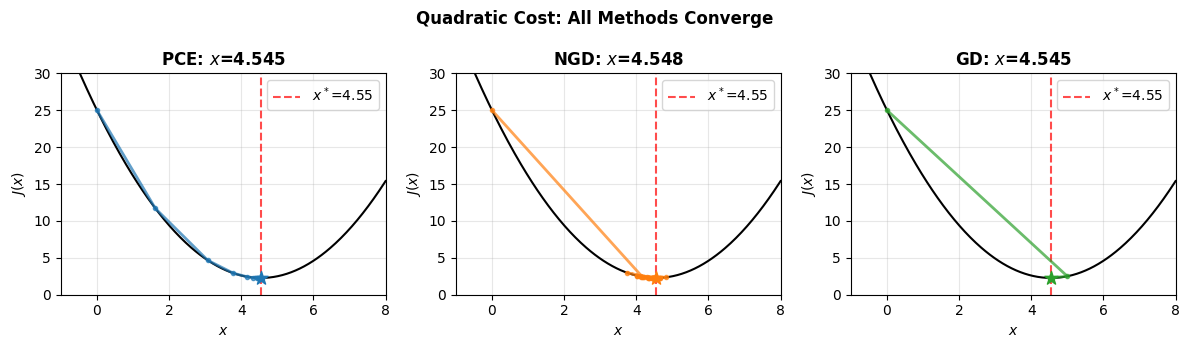

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
x = np.linspace(-1, 8, 300)

for ax, (h, name, c) in zip(axes, [(pce,'PCE','C0'), (ngd,'NGD','C1'), (gd,'GD','C2')]):
    ax.plot(x, cost_quadratic(x), 'k-', lw=1.5)
    ax.axvline(X_OPT, color='r', ls='--', alpha=0.7, label=f'$x^*$={X_OPT:.2f}')
    ax.plot(h['y'], h['cost'], c, lw=2, marker='o', ms=3, alpha=0.7)
    ax.scatter(h['y'][-1], h['cost'][-1], c=c, s=100, marker='*', zorder=5)
    ax.set(xlabel='$x$', ylabel='$J(x)$', xlim=(-1, 8), ylim=(0, 30))
    ax.set_title(f"{name}: $x$={h['y'][-1]:.3f}", fontweight='bold')
    ax.legend(loc='upper right')

fig.suptitle('Quadratic Cost: All Methods Converge', fontweight='bold')
plt.tight_layout()
plt.savefig('fig_quadratic.pdf', bbox_inches='tight')
plt.show()

## 4. Experiment 2: Discontinuous Barrier Cost

$$J(x) = (x - 5)^2 + 0.1 x^2 + 100 \cdot \mathbf{1}_{(2,3)}(x) + 100 \cdot \mathbf{1}_{(6,8)}(x)$$

Starting from $x_0 = 9.5$ (outside the optimal basin).

In [9]:
np.random.seed(42)
y0 = 9.5

pce = run_pce(cost_barriers, y0=y0, sigma=3.0, n_iter=n_iter)
np.random.seed(42)
ngd = run_ngd(cost_barriers, y0=y0, sigma=3.0, n_iter=n_iter)
gd = run_casadi(cost_barriers_casadi, y0=y0, lr=0.3)
gd_true_cost = [cost_barriers(np.array([y]))[0] for y in gd['y']]

print(f"{'Method':<10} {'Final y':>12} {'Final J':>12} {'Status':>12}")
print("-" * 48)
print(f"{'PCE':<10} {pce['y'][-1]:>12.4f} {pce['cost'][-1]:>12.4f} {'✓ Optimal':>12}")
print(f"{'NGD':<10} {ngd['y'][-1]:>12.4f} {ngd['cost'][-1]:>12.4f} {'✗ Stuck':>12}")
print(f"{'GD':<10} {gd['y'][-1]:>12.4f} {gd_true_cost[-1]:>12.4f} {'✗ Local min':>12}")
print("-" * 48)
print(f"{'Optimal':<10} {X_OPT:>12.4f} {J_OPT:>12.4f}")

Method          Final y      Final J       Status
------------------------------------------------
PCE              4.5457       2.2727    ✓ Optimal
NGD              1.3988      13.1642      ✗ Stuck
GD               9.4049      28.2482  ✗ Local min
------------------------------------------------
Optimal          4.5455       2.2727


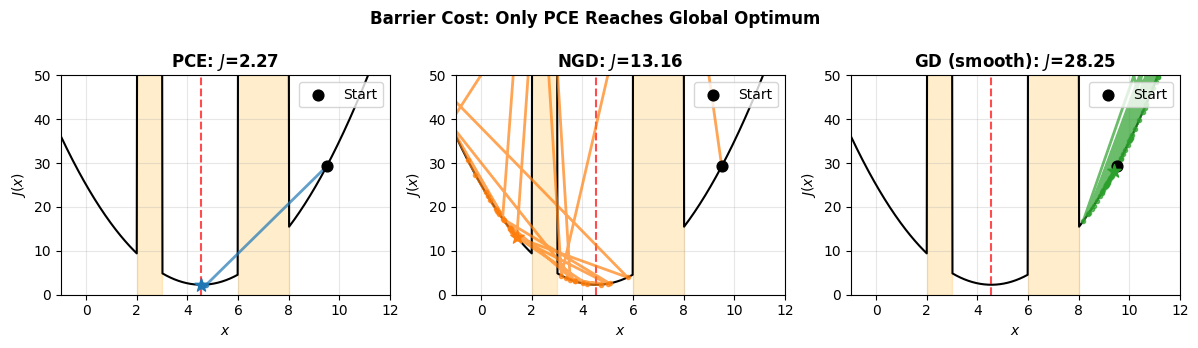

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
x = np.linspace(-1, 12, 500)

data = [(pce, pce['cost'], 'PCE', 'C0'), 
        (ngd, ngd['cost'], 'NGD', 'C1'), 
        (gd, gd_true_cost, 'GD (smooth)', 'C2')]

for ax, (h, costs, name, c) in zip(axes, data):
    ax.plot(x, cost_barriers(x), 'k-', lw=1.5)
    ax.axvspan(2, 3, alpha=0.2, color='orange')
    ax.axvspan(6, 8, alpha=0.2, color='orange')
    ax.axvline(X_OPT, color='r', ls='--', alpha=0.7)
    ax.plot(h['y'], costs, c, lw=2, marker='o', ms=3, alpha=0.7)
    ax.scatter(h['y'][0], costs[0], c='k', s=60, marker='o', zorder=5, label='Start')
    ax.scatter(h['y'][-1], costs[-1], c=c, s=100, marker='*', zorder=5)
    ax.set(xlabel='$x$', ylabel='$J(x)$', xlim=(-1, 12), ylim=(0, 50))
    ax.set_title(f"{name}: $J$={costs[-1]:.2f}", fontweight='bold')
    ax.legend(loc='upper right')

fig.suptitle('Barrier Cost: Only PCE Reaches Global Optimum', fontweight='bold')
plt.tight_layout()
plt.savefig('fig_barriers.pdf', bbox_inches='tight')
plt.show()

## 5. Covariance Schedule Comparison

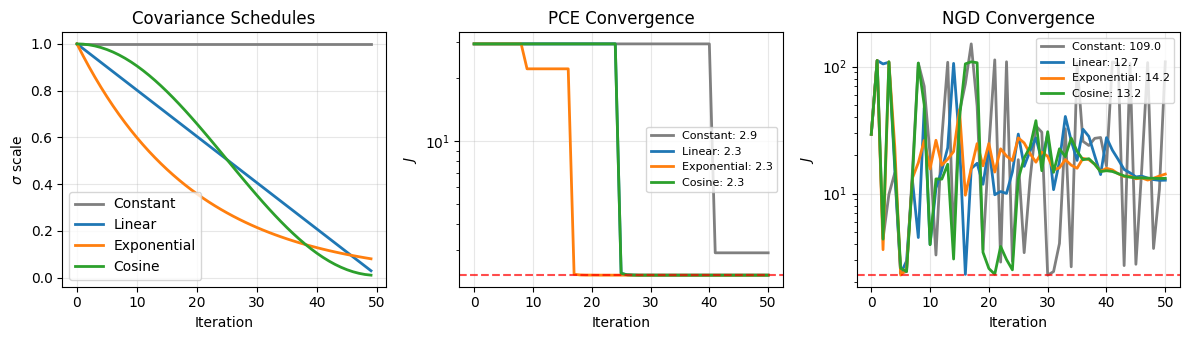

In [11]:
schedules = [
    (CovSchedule.CONSTANT, 'Constant', 'C7'),
    (CovSchedule.LINEAR, 'Linear', 'C0'),
    (CovSchedule.EXPONENTIAL, 'Exponential', 'C1'),
    (CovSchedule.COSINE, 'Cosine', 'C2')
]

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# Left: Schedule visualization
t = np.arange(n_iter)
for sched, name, c in schedules:
    scales = [cov_scale(i, n_iter, sched) for i in t]
    axes[0].plot(t, scales, c, lw=2, label=name)
axes[0].set(xlabel='Iteration', ylabel='$\\sigma$ scale', title='Covariance Schedules')
axes[0].legend()

# Middle & Right: Cost convergence
for ax, (run_fn, title) in zip(axes[1:], [(run_pce, 'PCE'), (run_ngd, 'NGD')]):
    for sched, name, c in schedules:
        np.random.seed(42)
        h = run_fn(cost_barriers, y0=9.5, sigma=3.0, n_iter=n_iter, schedule=sched)
        cost_key = 'cost'
        ax.plot(h[cost_key], c, lw=2, label=f"{name}: {h[cost_key][-1]:.1f}")
    ax.axhline(J_OPT, color='r', ls='--', alpha=0.7)
    ax.set(xlabel='Iteration', ylabel='$J$', yscale='log', title=f'{title} Convergence')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('fig_schedules.pdf', bbox_inches='tight')
plt.show()

## 6. Summary

| Method | Quadratic | Barriers | Notes |
|--------|-----------|----------|-------|
| PCE    | ✓ Optimal | ✓ Optimal | Sampling-based, handles discontinuities |
| NGD    | ✓ Optimal | ✗ Local  | Gradient estimate biased by barriers |
| GD     | ✓ Optimal | ✗ Local  | Smooth approximation creates false minima |